**TODO:**
- [x] Build NTEE-10 major groups.
- [x] Vectorize output labels.
- [x] Vectorize input texts.
- [x] Spell check.


In [1]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding


# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Code as 10 major groups.
major_group_dict={'I': ['A'],
                  'II': ['B'],
                  'III': ['C', 'D'],
                  'IV': ['E', 'F', 'G', 'H'],
                  'V': ['I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
                  'VI': ['Q'],
                  'VII': ['R', 'S', 'T', 'U', 'V', 'W'],
                  'VIII': ['X'],
                  'IX': ['Y'],
                  'X': ['Z'],
                 }
def ntee2major(string):
    global major_group_dict
    return [s for s in major_group_dict.keys() if string in major_group_dict[s]][0]

In [3]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])
df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc']
df_train['NTEE_M']=df_train['NTEE1'].apply(ntee2major)

len(df_train['mission_prgrm']), len(df_train['NTEE1'].drop_duplicates()), len(df_train['NTEE_M'].drop_duplicates())

(229472, 25, 9)

In [4]:
# Build training data frame.
small_num=0
while small_num<500: # Make sure each category has at least 500 records.
    trainDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(60000)
    small_num=trainDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']

# Build validation data frame.
small_num=0
while small_num<500: # Make sure each category has at least 500 records.
    valDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(60000)
    small_num=valDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']

In [5]:
# See the composition by NTEE major groups.
print(trainDF.groupby('NTEE_M').count()['EIN']/len(trainDF), '\n'*2, valDF.groupby('NTEE_M').count()['EIN']/len(valDF))

NTEE_M
I       0.111017
II      0.165617
III     0.049750
IV      0.117050
IX      0.038683
V       0.300617
VI      0.013383
VII     0.175250
VIII    0.028633
Name: EIN, dtype: float64 

 NTEE_M
I       0.110983
II      0.168417
III     0.051317
IV      0.114367
IX      0.037967
V       0.299867
VI      0.013500
VII     0.174300
VIII    0.029283
Name: EIN, dtype: float64


### Prepare labels.

In [6]:
def one_hot(label_list, class_list):
    int_encoder=LabelEncoder().fit(class_list) # Build the encoder.
    label_int_encoded=int_encoder.transform(label_list) # One-dimensional integer encoded.
    return np_utils.to_categorical(label_int_encoded) # Multi-dimensional binary/one-hot encoded.

y_train=one_hot(label_list=trainDF['NTEE_M'], class_list=list(major_group_dict.keys()))
y_val=one_hot(label_list=valDF['NTEE_M'], class_list=list(major_group_dict.keys()))

### Prepare input text.

In [7]:
stop_list=stopwords.words('english')+list(string.punctuation)
def tokenize_stopwords_remove(string):
    global stop_list
    return [s for s in nltk.word_tokenize(string) if s not in stop_list]

In [8]:
text_token_list_train=trainDF['mission_prgrm'].apply(tokenize_stopwords_remove)
text_token_list_val=valDF['mission_prgrm'].apply(tokenize_stopwords_remove)

In [ ]:
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(word_string_list):
    return [SpellChecker().correction(word=s).upper() for s in word_string_list]

# Parallel computing
p = Pool(48)
text_token_list_train=p.map(spellcheck, text_token_list_train)
text_token_list_val=p.map(spellcheck, text_token_list_val)
# Pool.map keep the original order of data passed to map.
# https://stackoverflow.com/questions/41273960/python-3-does-pool-keep-the-original-order-of-data-passed-to-map

In [ ]:
# Build word index for train and validation texts.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(text_token_list_train.to_list()+text_token_list_val.to_list())
print(list(tokenizer.word_index.items())[0:5])

In [ ]:
seq_encoding_text_train=tokenizer.texts_to_sequences(text_token_list_train)
seq_encoding_text_val=tokenizer.texts_to_sequences(text_token_list_val)

In [ ]:
# Pads sequences to the same length.
x_train=pad_sequences(sequences=seq_encoding_text_train,
                      maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                      dtype = "int32", padding = "post", truncating = "post", 
                      value = 0 # Zero is used for representing None or Unknown.
                     )
x_val=pad_sequences(sequences=seq_encoding_text_val,
                    maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                    dtype = "int32", padding = "post", truncating = "post", 
                    value = 0 # Zero is used for representing None or Unknown.
                     )

In [ ]:
# https://medium.com/@Petuum/embeddings-a-matrix-of-meaning-4de877c9aa27
# Note that in the embedding matrix above, each row corresponds to a word and each column corresponds to a dimension (axis). 
# Typically, we store this in a dense fashion, where we have a list of words and row ID’s which map to the corresponding row of the matrix. 
# For the above example, we’d have the following list in addition to the matrix:
# { hello: 0, there: 1, texas: 2, world: 3, … }

In [204]:
# !cd ~/work_dir/npo_classifier/dataset; mkdir glove.6B; wget http://nlp.stanford.edu/data/glove.6B.zip; 

## Classifier.

### Not using pre-trained embedding.

In [149]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index), # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=32, # Size of the vector space in which words will be embedded.
                           )

In [ ]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(max([len(s) for s in seq_encoding_text_train]),), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=len(y_train[0]), activation='softmax')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

In [150]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [185]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

# define the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(units=len(y_train[0]), activation='relu'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', precision, recall])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 33350, 32)         5723136   
_________________________________________________________________
flatten_9 (Flatten)          (None, 1067200)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               546406912 
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 2313      
Total params: 552,263,689
Trainable params: 552,263,689
Non-trainable params: 0
_________________________________________________________________
None


In [186]:
# fit the model
# Batch size: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
history=model.fit(x_train, y_train, validation_split=0.3, epochs=25, verbose=1)

Train on 42000 samples, validate on 18000 samples
Epoch 1/25
42000/42000 [==============================] - 4069s 97ms/step - loss: 5.1290 - acc: 0.6759 - precision: 0.0382 - recall: 0.0840 - val_loss: 5.0882 - val_acc: 0.6787 - val_precision: 0.0347 - val_recall: 0.0704
Epoch 2/25
42000/42000 [==============================] - 4118s 98ms/step - loss: 5.0941 - acc: 0.6784 - precision: 0.0347 - recall: 0.0699 - val_loss: 5.0882 - val_acc: 0.6787 - val_precision: 0.0343 - val_recall: 0.0690
Epoch 3/25
42000/42000 [==============================] - 4128s 98ms/step - loss: 5.0941 - acc: 0.6784 - precision: 0.0343 - recall: 0.0689 - val_loss: 5.0882 - val_acc: 0.6787 - val_precision: 0.0341 - val_recall: 0.0685
Epoch 4/25
42000/42000 [==============================] - 4137s 99ms/step - loss: 5.0941 - acc: 0.6784 - precision: 0.0341 - recall: 0.0684 - val_loss: 5.0882 - val_acc: 0.6787 - val_precision: 0.0341 - val_recall: 0.0683
Epoch 5/25
42000/42000 [==============================] - 4153

KeyboardInterrupt: 

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=1)
print('Accuracy: %f' % (accuracy*100))

### Use pre-trained GloVe embedding.

In [ ]:
import gensim.downloader as api
EMBEDDING_DIM=100
glove_word_vector=api.load('glove-wiki-gigaword-'+str(EMBEDDING_DIM))

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))

In [ ]:
for word, index in tqdm(tokenizer.word_index.items()):
    try:
        embedding_matrix[index] = glove_word_vector.get_vector(word)
    except:
        pass
        # words not found in embedding index will be all-zeros.

In [ ]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                            weights=[embedding_matrix],
                            trainable=False
                           )

In [ ]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

# define the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(units=10, activation='sigmoid'))
# model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(units=len(y_train[0]), activation='relu'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', precision, recall])
# summarize the model
print(model.summary())

# fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=50, verbose=1)

## Draft.

In [208]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
'''
x = GRU(units=128, activation='tanh', return_sequences=True)(embedded_sequences)

x = LSTM(units=256, activation='tanh', return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)

#x = LSTM(units=128, activation='tanh', return_sequences=True)(x)
#x = Dropout(0.2)(x)
'''
# x = Dropout(0.2)(x)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=9, activation='softmax')(x) #softmax

# x = Dense(units=512, activation='relu')(x)
# x = Dense(units=128, activation='relu')(x)
# preds = Dense(units=25, activation='sigmoid')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 200)         6692600   
_________________________________________________________________
flatten_13 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               102400512 
_________________________________________________________________
dense_39 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_40 (Dense)             (None, 9)                 1161      
Total params: 109,159,937
Trainable params: 102,467,337
Non-trainable params: 6,692,600
______________________________________________________

In [79]:
score = model.evaluate(x_val, y_val, batch_size=500, verbose=1)
score

60000/60000 [==============================] - 25s 412us/step


[0.19112927243113517, 0.9295742606123288, 0.1111111119389534, 1.0]

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

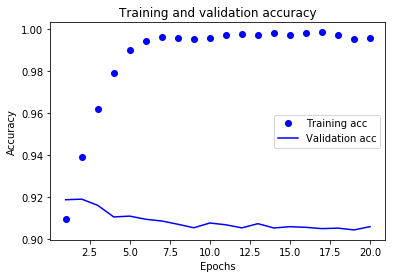

In [133]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [134]:
len([s.argmax() for s in y_prob if s.max()>.95])

9686

In [66]:
y_prob = model.predict(x_val)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

In [166]:
y_prob = model.predict(x_train[:-2000])
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_train[:-2000].argmax(axis=-1)

KeyboardInterrupt: 

In [67]:
df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

0.33516666666666667

In [68]:
df_val

,pred,true,prob
0,5,5,0.266944
1,0,0,0.350441
2,5,5,0.313711
3,0,4,0.357811
4,5,4,0.422023
5,3,5,0.287897
6,0,5,0.439866
7,5,7,0.391452
8,5,5,0.264276
9,0,0,0.383985


In [78]:
df_95=df_val[df_val.prob>.95]
len(df_95)

30

In [70]:
len(df_95[df_95.pred==df_95.true])/len(df_95)

0.9666666666666667

In [71]:
len(df_val[df_val.pred==df_val.true])

20110

In [72]:
df_val.pred.unique()

array([5, 0, 3, 2, 7])

In [73]:
len(df_train)

229472

In [74]:
len(trainDF)

60000

In [75]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0     14906.0  0.411876  0.130990  0.122192  0.333200  0.396974  0.443390   
2       344.0  0.305225  0.186596  0.107255  0.114524  0.324234  0.424039   
3     12621.0  0.282041  0.010827  0.182491  0.278944  0.286534  0.287893   
5     31841.0  0.326083  0.080582  0.137453  0.266784  0.301840  0.367833   
7       288.0  0.307610  0.062912  0.100972  0.264594  0.299208  0.342576   

                
           max  
pred            
0     1.265611  
2     1.071373  
3     0.537756  
5     0.775390  
7     0.498169

In [76]:
df_val.sample(20)

,pred,true,prob
49082,3,5,0.287850
43941,5,8,0.286016
58881,3,3,0.287897
44115,0,5,0.186938
37787,5,5,0.269300
58171,5,3,0.317108
5517,3,3,0.275014
47869,5,1,0.274429
9467,5,6,0.365315
58390,5,1,0.210359


In [77]:
df_95.pred.unique()

array([0, 2])